# Semantic segmentation

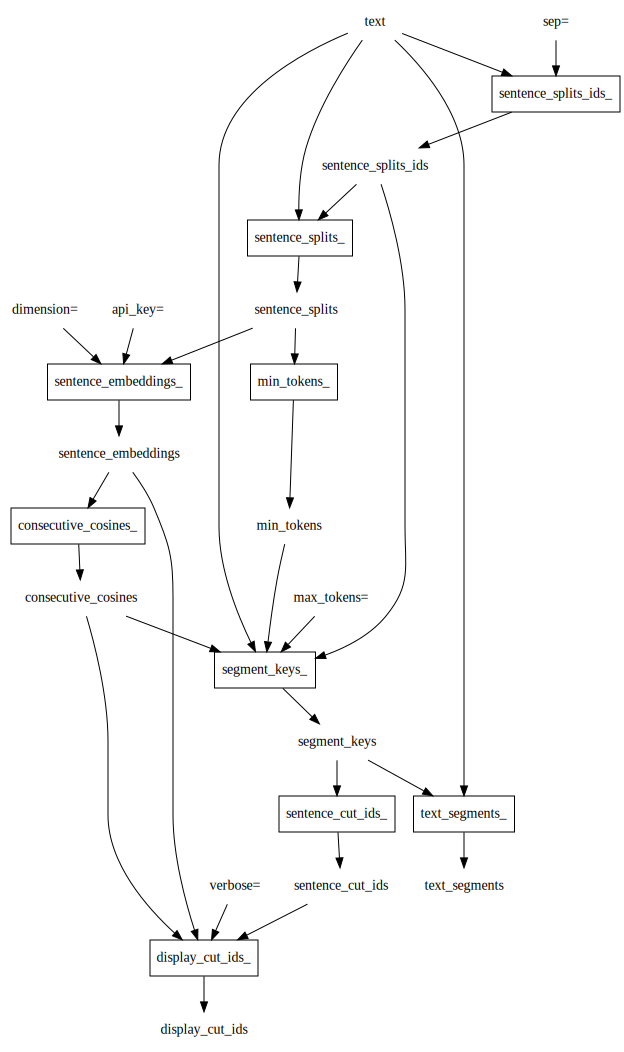

In [1]:
from segmentation_lib import segmentation_dag
segmentation_dag.dot_digraph()

In [2]:
segmentation_dag[:](text = "Je parle de la segmentation de texte. C'est un sujet technique pour faire du traitement de texte. Vraiment technique! Vous trouverez joint dans ce mail un example contrat. \n Veuillez vous y réferer pour rédiger les accords. Merci. Une fois fini, j'attends votre version du texte. n'est-ce pas?", max_tokens = 20)                 

min_tokens: 16
3
left number of tokens: 37
Je parle de la segmentation de texte. C'est un sujet technique pour faire du traitement de texte. Vraiment technique! Vous trouverez joint dans ce mail un example contrat.
right number of tokens: 38
 
 Veuillez vous y réferer pour rédiger les accords. Merci. Une fois fini, j'attends votre version du texte. n'est-ce pas?
-----


AssertionError: right_cosines and right_split_ids must have the same length

[6, 9]

# Retrieval functions

In [9]:
from raglab.retrieval.lib_alexis import dag, generate_split_keys
doc_embeddings = dag[:"doc_embeddings"]
top_k = dag["user_query":"top_k_segments"]

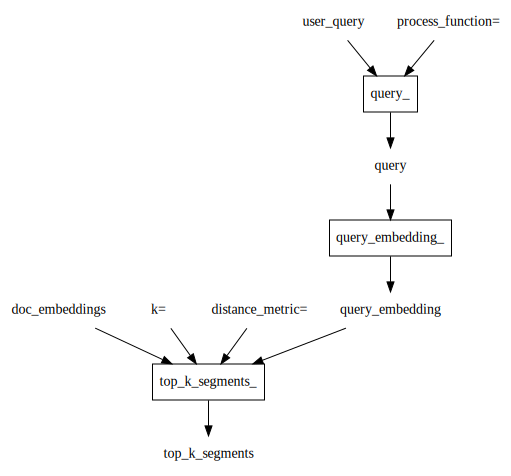

In [10]:
top_k.dot_digraph()

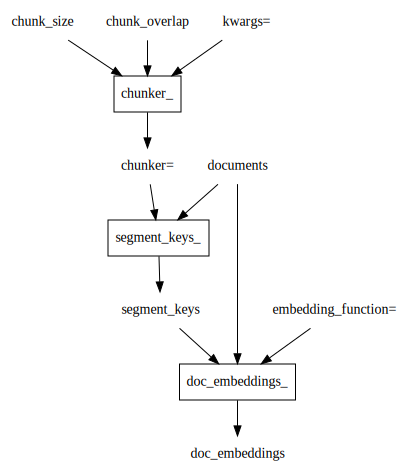

In [5]:
doc_embeddings.dot_digraph()

# Testing

test data

In [11]:
from dol import Files
from raglab.retrieval.lib_alexis import extension_base_wrap
test_responces = extension_base_wrap(Files("./data_ad/QA"))
test_documents = extension_base_wrap(Files("./data_ad/test_documents"))
print(f"test repsonces", list(test_responces))
print(f"test documents", list(test_documents))

test repsonces ['eval1.json', 'story_qa.json']
test documents ['Contrat_ONE1406.pdf', 'story.txt', 'contract1.txt', 'writers.txt']


In [12]:
erwan_contract = test_documents["Contrat_ONE1406.pdf"]

In [14]:
erwan_doc = {"erwan_contract": erwan_contract}

In [3]:
test_qa = test_responces["eval1.json"]
test_txt = test_documents["contract1.txt"]
test_doc = {"contract1": test_txt}

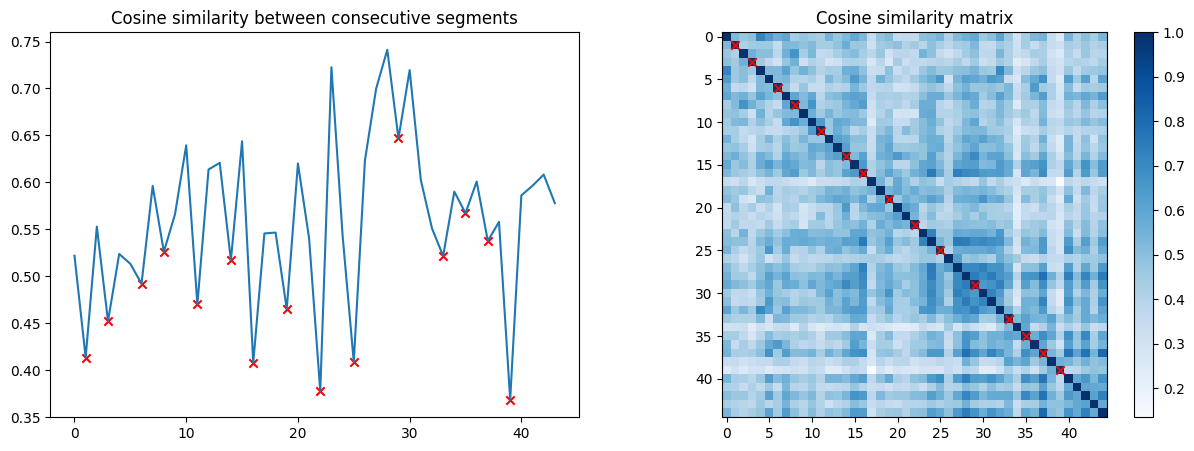

In [4]:
# display segmentation
segmentation_dag[:"display_cut_ids"](text=test_txt)

In [13]:
from functools import partial
_generate_split_keys =  partial(generate_split_keys, chunk_overlap=40, chunk_size=10_000)

In [15]:
from segmentation_lib import segment_keys
from functools import partial
segment_keys_= partial(segment_keys, language= "english")
doc_embed = doc_embeddings["chunker":](documents=erwan_doc, chunker = _generate_split_keys) # TODO add semantic chunker

TypeError: generate_split_keys() got multiple values for argument 'chunk_size'

In [18]:
from functools import partial
pipeline = partial(top_k, doc_embeddings=doc_embed)

In [19]:
score = 0
for query, responce in test_qa.items():
    print(f"\n-------------\n Query: {query}")
    print(f"Expected: {responce}")
    res = pipeline(user_query=query, k=1)
    segment_key=res[0]
    if responce in test_doc[segment_key[0]][segment_key[1]:segment_key[2]]:
        score += 1
        print("correct!")
    print(f"Predicted: {test_doc[segment_key[0]][segment_key[1]:segment_key[2]]}")

print(f"\nScore: {score}/{len(test_qa)}")



-------------
 Query: Quelle est le but de définir certain termes dans les GCP?
Expected: éviter toute ambigüité
correct!
Predicted: a.Dans les CGP, certains termes font l’objet d’une définition prévue dans cet article afin d’éviter toute ambigüité entre les parties quant à leur signification exacte. 
b.Ces définitions s’imposent donc aux Parties.

-------------
 Query: l'annexe peut-elle être séparée des GCP?
Expected: annexe s’intègre aux CGP et constitue un tout indissociable
correct!
Predicted: - Annexe(s) : désigne le(s) document(s) que les parties rédigent séparément et joignent au contrat. L’annexe s’intègre aux CGP et constitue un tout indissociable avec lui. Contrat ou CGP : il s’agit des présentes conditions générales également

-------------
 Query: Par quel terem générique est désigné le GCP?
Expected: désignées sous le terme générique de « Contrat »
Predicted: a.Dans les CGP, certains termes font l’objet d’une définition prévue dans cet article afin d’éviter toute ambigüi

# visualize embeddings

In [39]:
# dump .tsv file to save vectors
vectors = list(doc_embed.values()) + dag["user_query":"query_embedding"](user_query="Une personne qui habite une ville côtière")
labels = list(doc_embed.keys()) + ["Une personne qui habite une ville côtière"]


In [34]:
"a \n".replace("\n", "")

'a '

In [44]:
# visualisation of embaddings with labels
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(list(doc_embed.values()))
sentences = [d[key[0]][key[1]:key[2]] for key in doc_embed.keys()]
print(len(principalComponents), len(sentences))
sentence_embd = zip(sentences, principalComponents)
with open("embeddings_story.tsv", "w") as f:
    with open("embeddings_metadata_story.tsv", "w") as fm:
        for k, v in sentence_embd :
            fm.write(k.replace("\n", "") + "\n")
            f.write("\t".join([str(x).replace("\n", "") for x in v]) + "\n")
            print(v,k)


25 25
[ 0.263606   -0.16116216  0.24300912] Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à chercher des coquillages brillants et à
[ 0.15252536 -0.03040171 -0.14722567] chercher des coquillages brillants et à construire des châteaux de sable.
[ 0.32028301 -0.09492968  0.2574581 ] Un jour, alors qu'il se promenait sur la plage, Pierre découvrit une bouteille mystérieuse échouée sur le sable. Il la ramassa avec curiosité et la déboucha pour voir ce qu'elle contenait. À sa
[ 0.21093002  0.05010822 -0.19036478] pour voir ce qu'elle contenait. À sa grande surprise, une petite carte était enroulée à l'intérieur.
[ 0.2480553   0.02308763 -0.13970906] La carte indiquait un endroit secret sur l'île où se trouvait un trésor caché depuis des siècles. Excité par cette découverte, Pierre décida de partir à l'aventure pour trouver le trésor.
[0.31339917 0.07151561 0.13113321] Il marcha à trave

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.00505012 -0.01125633  0.02729863 ... -0.01323909 -0.01103879
 -0.01737863].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [9]:
for k in doc_embed:
    print(d[k[0]][k[1]:k[2]])
    print("\n")

Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre.


vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à


ses journées à explorer les plages, à chercher des coquillages brillants et à construire des


brillants et à construire des châteaux de sable.


Un jour, alors qu'il se promenait sur la plage, Pierre découvrit une bouteille mystérieuse échouée


une bouteille mystérieuse échouée sur le sable. Il la ramassa avec curiosité et la déboucha pour


avec curiosité et la déboucha pour voir ce qu'elle contenait. À sa grande surprise, une petite


À sa grande surprise, une petite carte était enroulée à l'intérieur.


La carte indiquait un endroit secret sur l'île où se trouvait un trésor caché depuis des siècles.


un trésor caché depuis des siècles. Excité par cette découverte, Pierre décida de partir à


découverte, Pierre décida de partir à l'aventure pour trouver le trésor.


Il marcha à travers la